In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import YearLocator, AutoDateFormatter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import laplace_asymmetric
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [38]:
#import dataset
df_complete = pd.read_excel('EA_Inflation.xlsx')
df_complete.head()

,TIME,HICP,CISS,HICPlog,HICPannualized,HICPann/400
0,1991-01-01,61.43461,0.149332,4.117973,0.038614,0.000097
1,1991-02-01,61.70840,0.121447,4.122420,0.040292,0.000101
2,1991-03-01,61.70048,0.093995,4.122292,0.037812,0.000095
3,1991-04-01,61.91118,0.068052,4.125701,0.037925,0.000095
4,1991-05-01,62.17755,0.065581,4.129994,0.040115,0.000100


In [3]:
df = df_complete.drop('TIME', axis=1)
df.head()

,HICP,CISS,HICPlog,HICPannualized,HICPann/400
0,61.43461,0.149332,4.117973,0.038614,0.000097
1,61.70840,0.121447,4.122420,0.040292,0.000101
2,61.70048,0.093995,4.122292,0.037812,0.000095
3,61.91118,0.068052,4.125701,0.037925,0.000095
4,62.17755,0.065581,4.129994,0.040115,0.000100


In [4]:
hicp = df['HICP'].values.astype(float) 
ciss = df['CISS'].values.astype(float) 

hicp_an = df['HICPannualized'].values.astype(float) 
hicp_growth = df['HICPann/400'].values.astype(float) 
hicp_lag = np.roll(hicp_an, 1)
hicp_lag[0] = 0
hicp_lag_growth = np.roll(hicp_growth, 1)
hicp_lag[0] = 0

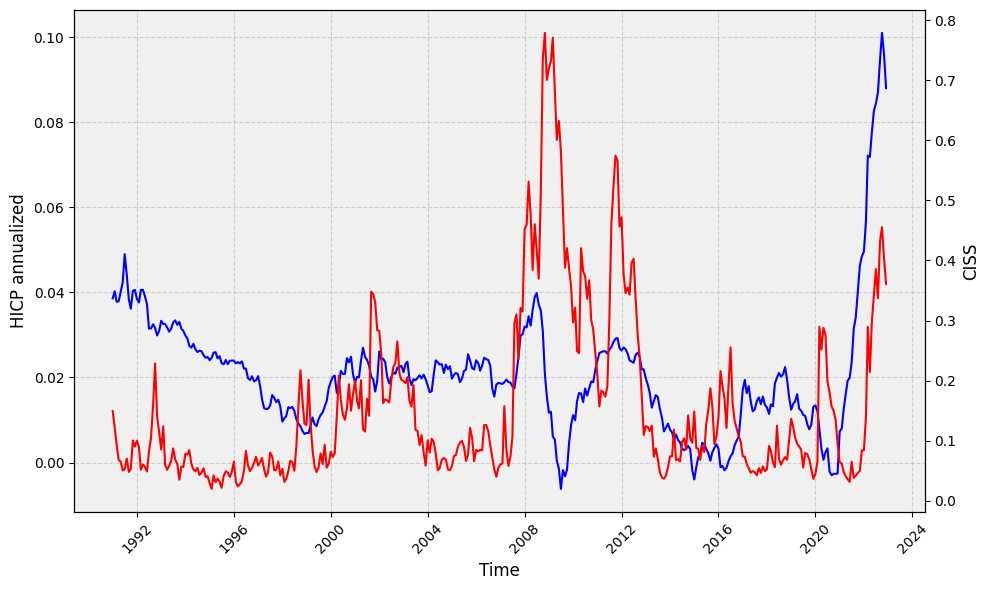

In [5]:

# Convert 'TIME' column to datetime
df_complete['TIME'] = pd.to_datetime(df_complete['TIME'])

# Create the fancy plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_complete['TIME'], df_complete['HICPannualized'], linestyle='-', color='b')

# Set plot title and labels
#ax.set_title('HICP Annualized Time Series and CISS', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('HICP annualized', fontsize=12)

# Customize the x-axis tick labels
ax.xaxis.set_tick_params(rotation=45, labelsize=10)

# Create a twin Axes for the secondary y-axis
ax2 = ax.twinx()
ax2.plot(df_complete['TIME'], df_complete['CISS'], linestyle='-', color='r')
ax2.set_ylabel('CISS', fontsize=12)

# Customize the x-axis tick labels
ax.xaxis.set_tick_params(rotation=45, labelsize=10)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Add a background color to the plot
ax.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


In [6]:
''' QL regression with package'''
X = np.column_stack((np.ones_like(hicp_an), hicp_lag, ciss))

# Use the standardized variables in the regression analysis
quant_reg_1 = sm.QuantReg(hicp_an, X).fit(q=0.1)
quant_reg_5 = sm.QuantReg(hicp_an, X).fit(q=0.5)
quant_reg_9 = sm.QuantReg(hicp_an, X).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary())  

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.7980
Model:                       QuantReg   Bandwidth:                    0.001179
Method:                 Least Squares   Sparsity:                      0.01174
Date:                Sun, 02 Jul 2023   No. Observations:                  384
Time:                        16:57:00   Df Residuals:                      381
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.000     -3.247      0.001      -0.002      -0.001
x1             0.9855      0.017     58.027      0.000       0.952       1.019
x2            -0.0058      0.001     -4.138      0.000      -0.009      -0.003
                         QuantReg Regression Results

In [8]:
#Autocorrelation paramter estimation PACKAGE 0.1, 0.5, 0.9
beta_pac1 = np.array([-0.0014, 0.9855, -0.0058])  
beta_pac5 = np.array([0.0003, 0.9951, -0.0011])  
beta_pac9 = np.array([0.0018, 1.0366, 0.0024])  
ε = hicp_an - X @ beta_pac1
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho PAC 0.1= ", theta_hat)

ε = hicp_an - X @ beta_pac5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho PAC 0.5= ", theta_hat)

ε = hicp_an - X @ beta_pac9
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho PAC 0.9= ", theta_hat)

rho PAC 0.1=  [[0.56112542]]
rho PAC 0.5=  [[0.22460575]]
rho PAC 0.9=  [[0.55479544]]


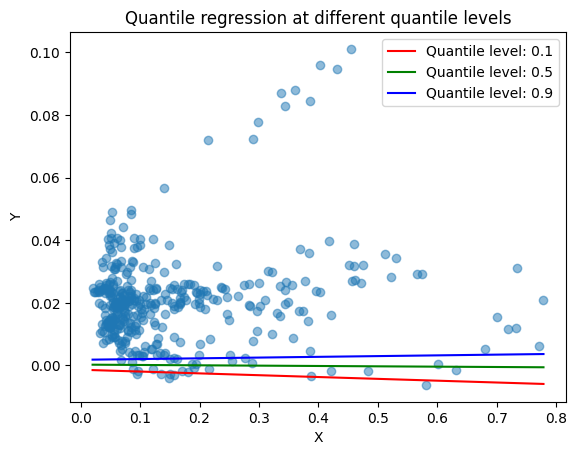

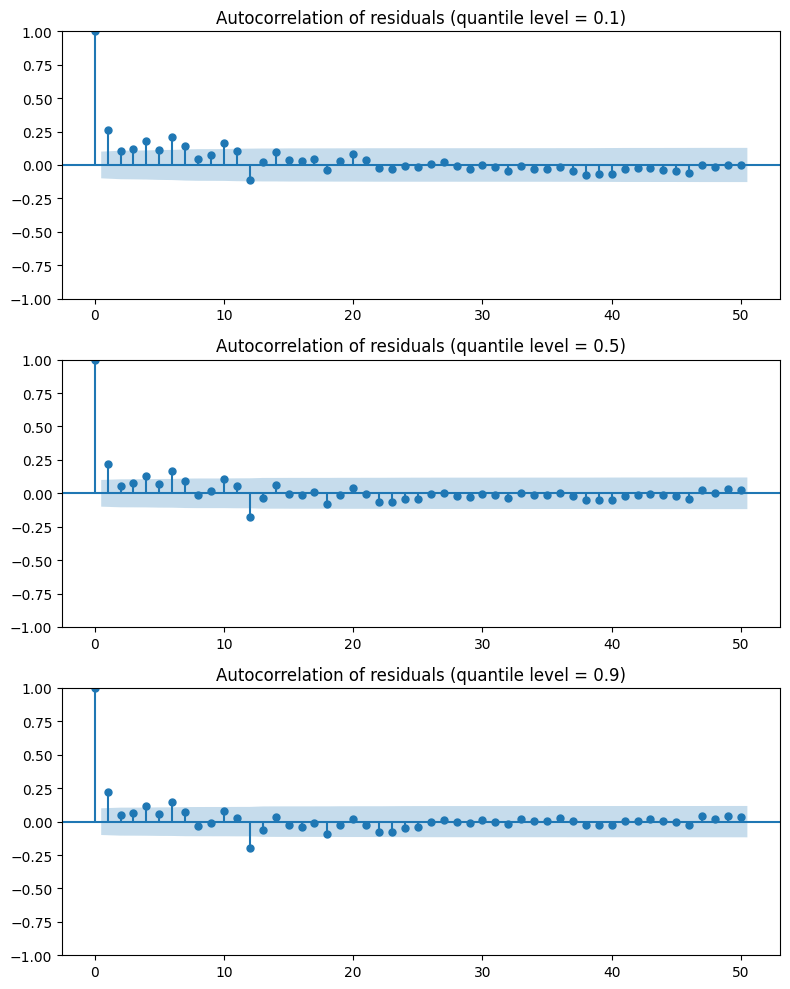

In [9]:
################################ Quantile regression plot ##############################
fig, ax = plt.subplots()
ax.scatter(ciss, hicp_an, alpha=0.5)

    # Generate x values for the regression lines
x_vals = np.linspace(np.min(ciss), np.max(ciss), 100)
y_vals_lag = np.linspace(np.min(hicp_lag), np.max(hicp_lag), 100)
    # Plot the regression lines
ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Quantile regression at different quantile levels')
plt.show()

################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, lags=50, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, lags=50, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

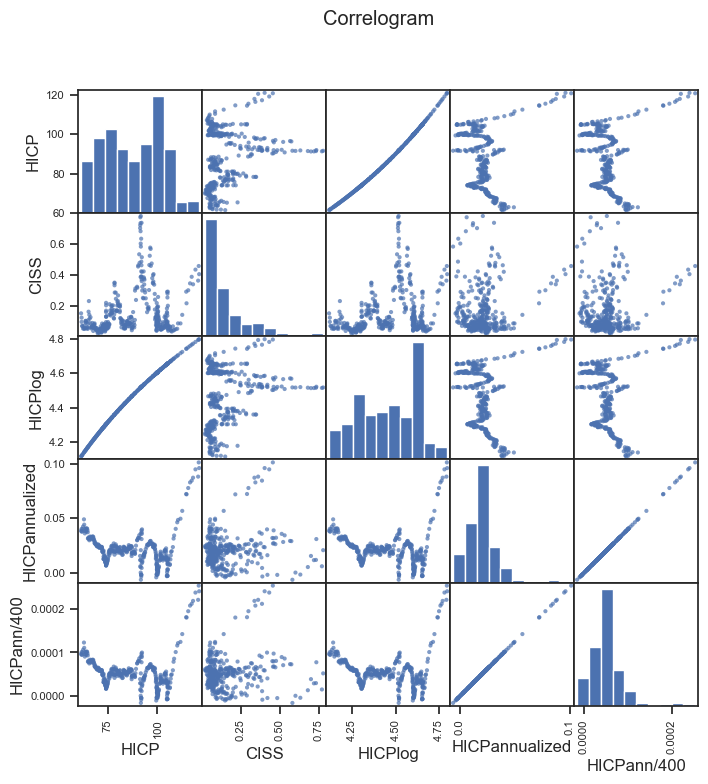

In [17]:

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

correlation_matrix = df.corr()

# Create the scatterplot matrix
scatter_matrix(df, alpha=0.7, figsize=(8, 8), diagonal='hist')

# Set the title of the plot
plt.suptitle("Correlogram")

# Display the plot
plt.show()

       lb_stat     lb_pvalue
1    26.115209  3.216405e-07
2    30.501920  2.380083e-07
3    36.237929  6.669284e-08
4    48.327605  8.064365e-10
5    53.329845  2.877660e-10
6    70.331295  3.496615e-13
7    78.607370  2.647996e-14
8    79.325487  6.682335e-14
9    81.603727  7.755835e-14
10   92.210124  1.950257e-15
11   96.729208  7.915585e-16
12  101.701530  2.582647e-16
13  101.855916  7.241672e-16
14  105.897192  3.480287e-16
15  106.458901  7.690015e-16
16  106.736928  1.864869e-15
17  107.631774  3.360679e-15
18  108.318984  6.465022e-15
19  108.617173  1.432516e-14
20  111.181232  1.195483e-14
21  111.831204  2.200082e-14
22  112.068944  4.707115e-14
23  112.365229  9.622193e-14
24  112.390068  2.151397e-13
25  112.535982  4.485808e-13
26  112.578923  9.554370e-13
27  112.724498  1.917083e-12
28  112.776406  3.918066e-12
29  113.101828  7.082668e-12
30  113.106495  1.424303e-11
31  113.222829  2.700339e-11
32  113.956724  4.008470e-11
33  114.002607  7.583297e-11
34  114.342531

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


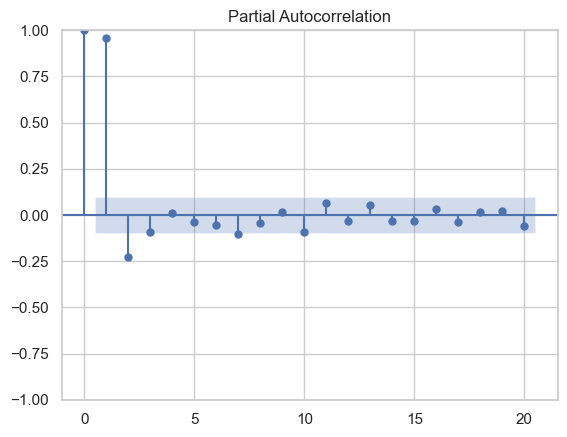

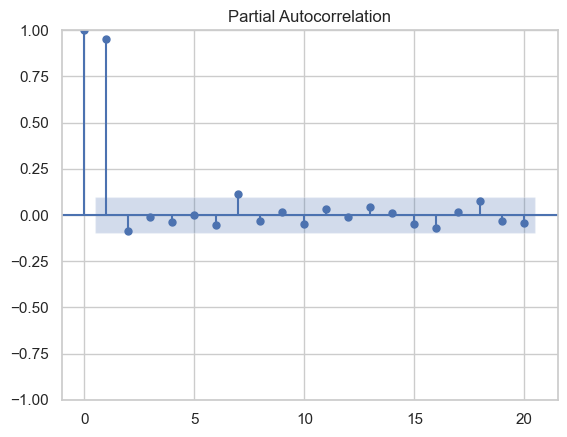

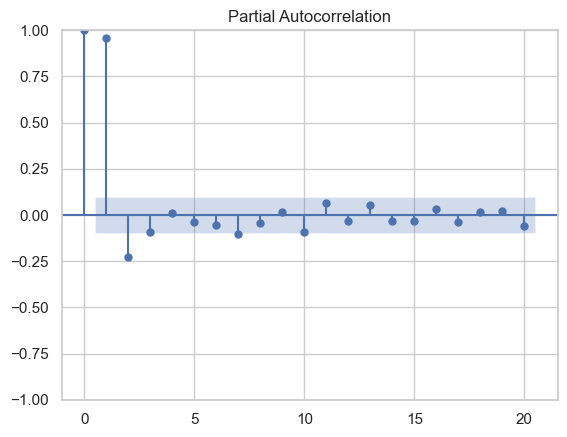

In [45]:
# Perform Ljung-Box test with up to 10 lags
lbtest = acorr_ljungbox(residuals_1, lags=50)

# Print p-values for each lag
print(lbtest)
# Perform Durbin-Watson test
dwtest = durbin_watson(residuals_1)

# Print test statistic
print(dwtest)

# Plot PACF of the time series
plot_pacf(ciss, lags=20)
plot_pacf(hicp_an, lags=20)

In [10]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['HICPannualized'].values
    T = min(M, len(y_dataset))
    y = df['HICPannualized'].values[:T]
    x = df['CISS'].values[:T]  # extract data

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        epsilon = np.random.randn(T) # Generate new errors for each iteration
        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        εg = y - X @ beta_gls
        εg = εg.reshape((-1, 1))
        ε_lagg = np.roll(εg, 1)
        ε_lagg[0] = 0
        ε_lagg = ε_lagg.reshape((-1, 1))
        theta_gls = np.linalg.inv(ε_lagg.T @ ε_lagg) @ ε_lagg.T @ εg
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)

In [13]:
M=1000
initial_params = 0.0003, 0.9951, -0.0011, 1, 0.0003, 0.9951, -0.0011, 1
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [-0.008627036037002635]
OLS beta_hat:  [0.013968111190326633]
OLS gamma_hat:  [-0.1584842210209773]
OLS theta_hat:  [1.0000000000000195]
GLS alpha_hat:  [-0.008629635650336677]
GLS beta_hat:  [0.013337028707090842]
GLS gamma_hat:  [-0.15861448624160465]
GLS theta_hat:  [0.001264021839234325]


In [15]:
#Autocorrelation parameter estimation OLS
beta_ols5 = np.array([-0.0086, 0.0140, -0.1584])  
beta_gls5 = np.array([-0.0086, 0.0133, -0.1586]) 
 
ε = hicp_an - X @ beta_ols5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho OLS 0.5 = ", theta_hat)

ε = hicp_an - X @ beta_gls5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho GLS 0.5 = ", theta_hat)

rho OLS 0.5 =  [[0.99871833]]
rho GLS 0.5 =  [[0.99871667]]


ASYMMETRIC LAPLACE ESTIMATION

In [22]:
def Laplace_estimation(df, p, M, params0):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['HICPannualized'].values
    T = min(M, len(y_dataset))
    y = df['HICPannualized'].values[:T]
    x = df['CISS'].values[:T]  # extract data
        #epsilon_y = df['epsilon_y'].values[:T]
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    def log_l_Asym_Lap(params, X, y):
        α, β, γ = params  # Separate the parameters
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1 - p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2 * p) / p * (1 - p)
        
        # Calculate the log-likelihood
        ll -= np.sum(np.log(np.sqrt(1/z)) + 0.5 * ((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2) / (τ_2 * z))
        return -ll

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Powell')  # minimize the negative log-likelihood #method='Powell'
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))

    return beta_matrix


In [23]:
#Estimation at p=0.1 LA 0.1
params1 = np.array([-0.0014, 0.9855, -0.0058], dtype=float) 
result_matrix = Laplace_estimation(df, 0.1, 1000, params1)


Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[-0.18572671  0.13658238  1.10210518]


In [24]:
#Estimation at LA 0.5
params5 = np.array([0.0003, 0.9951, -0.0011], dtype=float) #results from OLS package p=0.5
result_matrix = Laplace_estimation(df, 0.5, 1000, params5)


Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[-0.11790606  0.14148084  0.72169371]


In [25]:
#Estimation at p=0.9 LAP
params9 = np.array([0.0018, 1.0366, 0.0024], dtype=float) #results from OLS package p=0.9
result_matrix = Laplace_estimation(df, 0.9, 1000, params5)


Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[-0.20713994  0.15404919  0.79725004]


In [26]:
#Autocorrelation parameter estimation ASYMMETRIC LAPLACE p=0.1, 0.5, 0.9
beta_lap1 = np.array([-0.1857, 0.1366, 1.1021])  
beta_lap5 = np.array([-0.1179, 0.1415, 0.7217])  
beta_lap9 = np.array([-0.2071, 0.1540, 0.7972])  
ε = hicp_an - X @ beta_lap1
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho LAP 0.1 = ", theta_hat)

ε = hicp_an - X @ beta_lap5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho LAP 0.5 = ", theta_hat)

ε = hicp_an - X @ beta_lap9
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho LAP 0.9 = ", theta_hat)

rho LAP 0.1 =  [[0.95510245]]
rho LAP 0.5 =  [[0.95486216]]
rho LAP 0.9 =  [[0.97189487]]


EM ALGORITH ESTIMATION

In [27]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y_dataset = df['HICPannualized'].values
    T = len(y_dataset)
    y = df['HICPannualized'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    y = np.array(y)
    x = np.array(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)

        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        
        #μ
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))

        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse

        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

    #return β_values

In [28]:
#EM algorithm estimation p=0.1
n = 384
p = 0.1
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([-0.0014, 0.9855, -0.0058]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [-23826.58958025   -481.75770837  -3703.26766314]
Iteration 2: [-0.06089416 -0.00124743 -0.00954283]
Iteration 3: [-0.0610975   1.12534846 -0.01532325]
Iteration 4: [-0.06070335  1.16077615 -0.01939519]
Iteration 5: [-0.06073571  1.14867553 -0.01844848]
Iteration 6: [-0.06089689  1.1617217  -0.0194829 ]
Iteration 7: [-0.06119055  1.16326286 -0.01868469]
Iteration 8: [-0.06223758  1.21687701 -0.0194376 ]
Iteration 9: [-0.06106848  1.13456514 -0.01697889]
Iteration 10: [-0.0604268   1.07902802 -0.01414259]
Iteration 11: [-0.06071403  1.03445803 -0.00917835]
Iteration 12: [-0.06093634  1.08545553 -0.01209332]


In [29]:
#EM algorithm estimation p=0.5
n = 384
p = 0.5
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0003, 0.9951, -0.0011]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [12756.31084258   410.99952574  2619.10848758]
Iteration 2: [-4.22178255e-08  1.71167671e-04 -2.10921932e-07]
Iteration 3: [-1.62802475e+00  6.59109783e+03 -8.20602696e+00]
Iteration 4: [-1.36794096e-04  5.43683685e-01 -6.16293567e-04]
Iteration 5: [-5.51152360e-04  2.05826964e+00 -1.34153341e-03]
Iteration 6: [-2.74761761e-04  1.05197135e+00 -4.55124850e-04]
Iteration 7: [-2.39129885e-04  1.03287895e+00  9.61953677e-04]
Iteration 8: [-3.31164206e-04  1.07365401e+00 -1.99543283e-03]
Iteration 9: [-2.62443824e-04  1.06561825e+00 -1.59735748e-03]
Iteration 10: [-2.28852080e-04  1.06223997e+00 -1.41557875e-03]
Iteration 11: [-4.07061933e-04  9.94807449e-01  3.68493149e-03]
Iteration 12: [-2.67301182e-04  1.06070569e+00 -1.15821758e-03]


In [30]:
#EM algorithm estimation p=0.5
n = 1000
p = 0.9
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0018, 1.0366, 0.0024]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [65055.87363502  1354.61680299 10274.47416223]
Iteration 2: [0.05779372 0.00118739 0.00905696]
Iteration 3: [ 0.05698029  1.37290518 -0.01320737]
Iteration 4: [0.05775802 1.12289332 0.00183678]
Iteration 5: [0.05774901 1.1201557  0.00199844]
Iteration 6: [5.75870865e-02 1.13540047e+00 7.45437203e-04]
Iteration 7: [0.05726975 1.14174509 0.00122819]
Iteration 8: [5.61429209e-02 1.19580893e+00 6.57569592e-04]
Iteration 9: [0.05736741 1.11878252 0.00256839]
Iteration 10: [0.05805665 1.06584547 0.00514065]
Iteration 11: [0.05775495 1.02708373 0.00989583]
Iteration 12: [0.05750103 1.07589224 0.00717368]


In [31]:
#Autocorrelation parameter estimation EM  p=0.1, 0.5, 0.9
beta_em1 = np.array([-0.0609, 1.0855, -0.0121])  
beta_em5 = np.array([-0.0002, 1.0607, -0.0011])  
beta_em9 = np.array([0.0578, 1.0271, 0.0099])  
ε = hicp_an - X @ beta_em1
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho EM 0.1 = ", theta_hat)

ε = hicp_an - X @ beta_em5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho EM 0.5 = ", theta_hat)

ε = hicp_an - X @ beta_em9
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho EM 0.9 = ", theta_hat)

rho EM 0.1 =  [[0.99539207]]
rho EM 0.5 =  [[0.2403725]]
rho EM 0.9 =  [[0.9999165]]


FORECASTS

In [32]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['HICPannualized'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['HICPannualized'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))
        

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)
        
    return mse_list


In [33]:
df = pd.read_excel('EA_Inflation.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

beta_lap = np.array([-0.1179, 0.1415, 0.7217])
beta_em = np.array([-0.0002, 1.0607, -0.0011])
beta_ols = np.array([-0.0086, 0.0140, -0.1585])
beta_gls = np.array([0.0086, 0.0133, -0.1586])
beta_pac = np.array([0.0003, 0.9951, -0.0011])

betas = [beta_lap, beta_em, beta_ols, beta_gls, beta_pac]
beta_names = ['LAP', 'EM', 'OLS', 'GLS', 'PAC']

mse_values = []  # List to store the average MSE values for each horizon and beta combination

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list = recursive_poos(df_complete, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))

# Print the mse_values list
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MFSE for {beta_name}, horizon {horizon}: {avg_mse}")

Average MFSE for LAP, horizon 1: 0.010488438850672025
Average MFSE for LAP, horizon 2: 0.010508115713034245
Average MFSE for LAP, horizon 3: 0.010521872941813212
Average MFSE for LAP, horizon 4: 0.010527669064363837
Average MFSE for LAP, horizon 5: 0.010530427496681266
Average MFSE for LAP, horizon 6: 0.0105360660391725
Average MFSE for LAP, horizon 7: 0.01054242680416884
Average MFSE for LAP, horizon 8: 0.010550346914581597
Average MFSE for EM, horizon 1: 7.997750300553616e-05
Average MFSE for EM, horizon 2: 5.959835329778769e-05
Average MFSE for EM, horizon 3: 4.7296127780214655e-05
Average MFSE for EM, horizon 4: 3.80829615762936e-05
Average MFSE for EM, horizon 5: 3.1990835349975875e-05
Average MFSE for EM, horizon 6: 2.7851829225487268e-05
Average MFSE for EM, horizon 7: 2.4595846885952883e-05
Average MFSE for EM, horizon 8: 2.1904296290200673e-05
Average MFSE for OLS, horizon 1: 0.005440993472653704
Average MFSE for OLS, horizon 2: 0.00539323520143266
Average MFSE for OLS, horizo

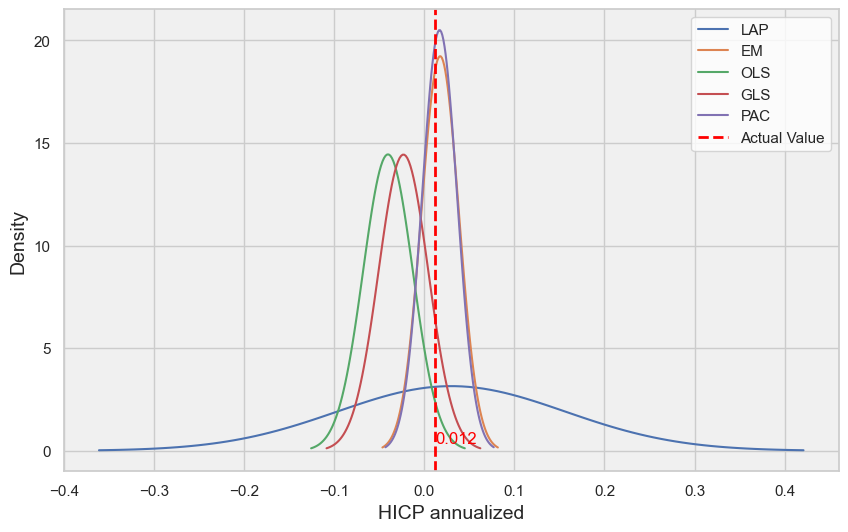

In [34]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []
    predictive_densities = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['HICPannualized'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['HICPannualized'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        if horizon == 1 and vintage == np.datetime64('2008-10-01'):
            predictive_density = norm(loc=np.mean(y_forecast), scale=np.std(y_forecast))
            predictive_densities.append(predictive_density)

    return mse_list, predictive_densities


df = pd.read_excel('EA_Inflation.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizon = 1

beta_lap = np.array([-0.1179, 0.1415, 0.7217])
beta_em = np.array([-0.0002, 1.0607, -0.0011])
beta_ols = np.array([-0.0086, 0.0140, -0.1585])
beta_gls = np.array([0.0086, 0.0133, -0.1586])
beta_pac = np.array([0.0003, 0.9951, -0.0011])

betas = [beta_lap, beta_em, beta_ols, beta_gls, beta_pac]#beta_pac
beta_names = ['LAP', 'EM', 'OLS', 'GLS', 'PAC'] #'PAC'

models = len(betas)

# Select the vintage for the plot
vintage = np.datetime64('2009-01-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'HICPannualized']
#ax.text(actual_value, 0.05, f'Actual Value: {actual_value:.3f}', color='red', fontsize=12, ha='center', va='center')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')


ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')
ax.set_facecolor('#f0f0f0')
# Set the plot title and labels
#ax.set_title(f'Predictive Densities for Vintage 2009-M1', fontsize=16)
ax.set_xlabel('HICP annualized', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()


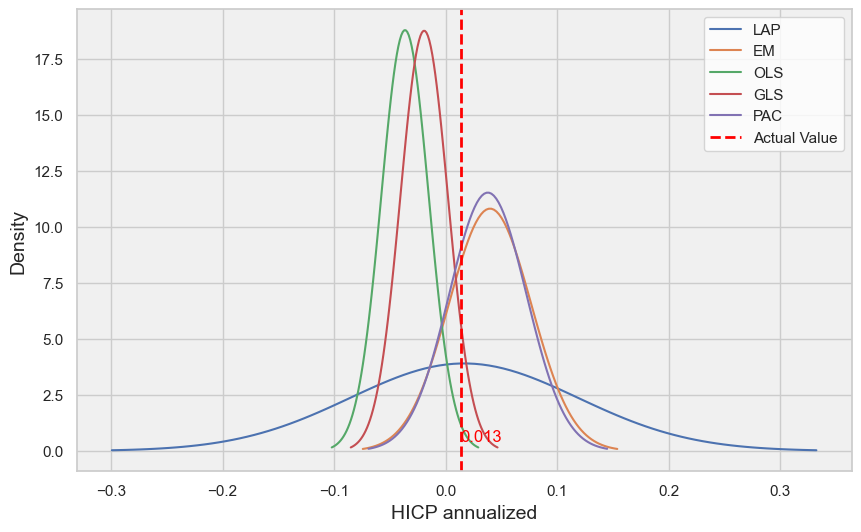

In [35]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []
    predictive_densities = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['HICPannualized'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['HICPannualized'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        if horizon == 1 and vintage == np.datetime64('2020-05-01'):
            predictive_density = norm(loc=np.mean(y_forecast), scale=np.std(y_forecast))
            predictive_densities.append(predictive_density)

    return mse_list, predictive_densities


df = pd.read_excel('EA_Inflation.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizon = 1
beta_lap = np.array([-0.1179, 0.1415, 0.7217])
#beta_lap = np.array([0.0003, 0.9951, -0.0011])
beta_em = np.array([-0.0002, 1.0607, -0.0011])
beta_ols = np.array([-0.0086, 0.0140, -0.1585])
beta_gls = np.array([0.0086, 0.0133, -0.1586])
beta_pac = np.array([0.0003, 0.9951, -0.0011])

betas = [beta_lap, beta_em, beta_ols, beta_gls, beta_pac] #beta_pac
beta_names = ['LAP', 'EM', 'OLS', 'GLS', 'PAC'] #'PAC'
models = len(betas)

# Select the vintage for the plot
vintage = np.datetime64('2020-01-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'HICPannualized']
#ax.text(actual_value, 0.05, f'Actual Value: {actual_value:.3f}', color='red', fontsize=12, ha='center', va='center')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')


ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')
ax.set_facecolor('#f0f0f0')
# Set the plot title and labels
#ax.set_title(f'Predictive Densities for Vintage 2022-05', fontsize=16)
ax.set_xlabel('HICP annualized', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()

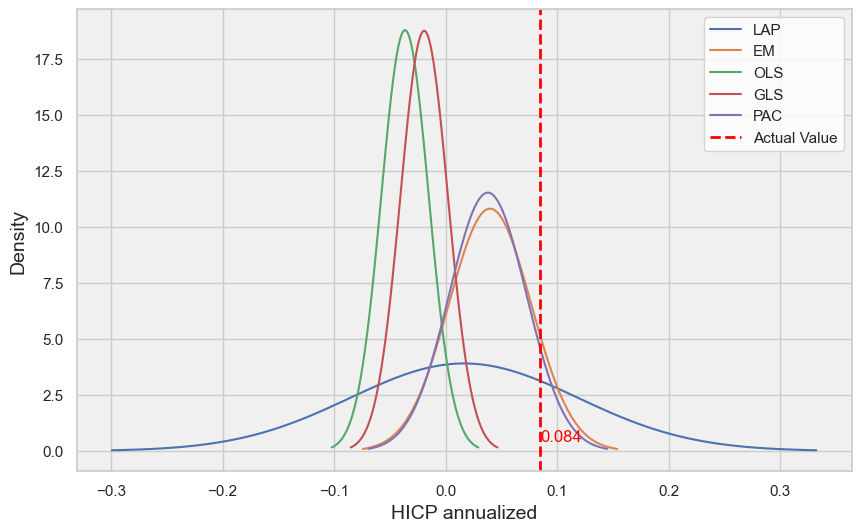

In [36]:
# Select the vintage for the plot
vintage = np.datetime64('2022-07-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'HICPannualized']
#ax.text(actual_value, 0.05, f'Actual Value: {actual_value:.3f}', color='red', fontsize=12, ha='center', va='center')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')


ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')
ax.set_facecolor('#f0f0f0')
#ax.set_title(f'Predictive Densities for Vintage 2022-05', fontsize=16)
ax.set_xlabel('HICP annualized', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()